# MagmaClust - Distinct Input, Shared Hyperparameters, Cluster Hyperparameters

---

## Setup

In [1]:
# Jax configuration
USE_JIT = True
USE_X64 = True
DEBUG_NANS = False
VERBOSE = False

In [2]:
# Standard library imports
import os
os.environ['JAX_ENABLE_X64'] = str(USE_X64).lower()

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

from functools import partial
from copy import deepcopy

In [3]:
# Third party
import jax
jax.config.update("jax_disable_jit", not USE_JIT)
jax.config.update("jax_debug_nans", DEBUG_NANS)

In [4]:
# Third party
import jax
jax.config.update("jax_disable_jit", not USE_JIT)
jax.config.update("jax_debug_nans", DEBUG_NANS)

import kernax
kernax.config.parameter_transform = "softplus"  # Important for the stability of the optimisation
from kernax import WhiteNoiseKernel, SEKernel

import pandas as pd
from matplotlib import pyplot as plt

In [5]:
# Local
from MagmaClustPy.utils import split_db
from MagmaClustPy.means import ZeroMean
from MagmaClustPy.models import BaseLikelihood, MagmaClust

INFO:2026-02-23 09:02:11,806:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/MagmaPipelines/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2026-02-23 09:02:11,806 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/MagmaPipelines/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


In [6]:
# Config
key = jax.random.PRNGKey(0)
test_db_size = "small"
nb_cluster = 4
pred_id = 0
grid_size = 250  # number of points in the grid
grid_margin = 5  # grid goes from min(all_inputs) - margin to max(all_inputs) + margin
train_pred_ratio = 0.8  # ratio of train/pred tasks
pred_test_ratio = 0.7  # ratio of pred/test points in each pred task

---

## Model use

##### Setup

In [7]:
db = pd.read_csv(f"./datasets/K={nb_cluster}/{test_db_size}_distinct_input_shared_hp.csv")
db_train, db_pred, db_test = split_db(db, train_ratio=train_pred_ratio, pred_ratio=pred_test_ratio)

/opt/miniconda3/envs/MagmaPipelines/lib/python3.12/site-packages/MagmaClustPy/utils.py:210: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  db_test = db_pred.groupby("Task_ID", group_keys=False).apply(
/opt/miniconda3/envs/MagmaPipelines/lib/python3.12/site-packages/MagmaClustPy/utils.py:213: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  db_pred = db_pred.groupby("Task_ID", group_keys=False).apply(


In [8]:
mean_kernel = 100. * SEKernel(length_scale=1.3)
task_kernel_train = 1. * SEKernel(length_scale=1.2) + WhiteNoiseKernel(noise=2.)
task_kernel_pred = deepcopy(task_kernel_train)

In [9]:
model = MagmaClust(k=nb_cluster, likelihood=BaseLikelihood(), prior_mean=ZeroMean(), mean_kernel=mean_kernel, task_kernel_train=task_kernel_train, task_kernel_pred=task_kernel_pred, shared_hp=True, cluster_hp=True)

In [10]:
model.load_train_data(db_train)
model.load_pred_data(db_pred)
model.load_test_data(db_test)

In [11]:
model.fit()

2026-02-23 09:02:13,826 - INFO - Iteration    0	Llhs:          inf,          inf	Conv. Ratio: inf	
	Mean kernel: 100.00 * SEKernel(length_scale=1.30)
	Task kernel: [1.00 ± 0.00]₄ * SEKernel(length_scale=[1.20 ± 0.00]₄) + WhiteNoiseKernel(noise=[2.00 ± 0.00]₄)
2026-02-23 09:02:15,277 - INFO - Iteration    1	Llhs:       0.0000,     547.3558	Conv. Ratio: inf	
	Mean kernel: 100.00 * SEKernel(length_scale=1.32)
	Task kernel: [3.97 ± 1.21]₄ * SEKernel(length_scale=[0.86 ± 0.18]₄) + WhiteNoiseKernel(noise=[0.08 ± 0.06]₄)
2026-02-23 09:02:16,109 - INFO - Iteration    2	Llhs:       0.0000,     520.1680	Conv. Ratio: 0.04967	
	Mean kernel: 100.00 * SEKernel(length_scale=1.34)
	Task kernel: [4.32 ± 1.63]₄ * SEKernel(length_scale=[1.01 ± 0.20]₄) + WhiteNoiseKernel(noise=[0.07 ± 0.05]₄)
2026-02-23 09:02:16,132 - INFO - Iteration    3	Llhs:       0.0000,     507.9243	Conv. Ratio: 0.02354	
	Mean kernel: 446.88 * SEKernel(length_scale=1.45)
	Task kernel: [4.43 ± 1.79]₄ * SEKernel(length_scale=[1.07 ± 0

In [12]:
model.generate_grid(grid_size)
model.grid_pred.shape

(250, 1)

In [13]:
pred_means, pred_covs = model.predict()
pred_means.shape, pred_covs.shape

((4, 4, 250), (4, 4, 250, 250))

##### Test

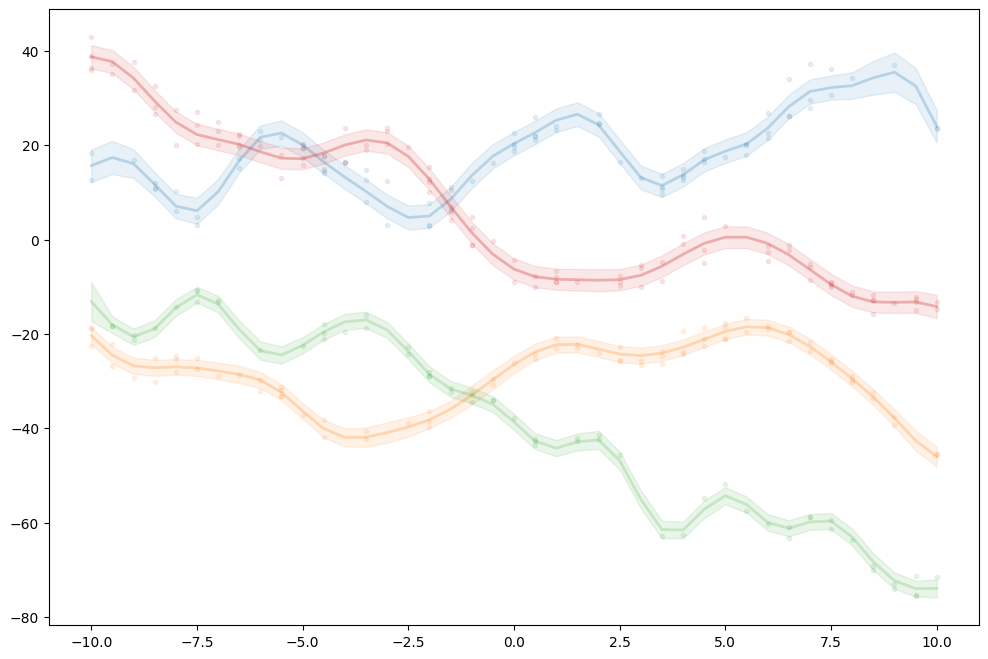

In [14]:
model.plot_mean_processes()
plt.show()

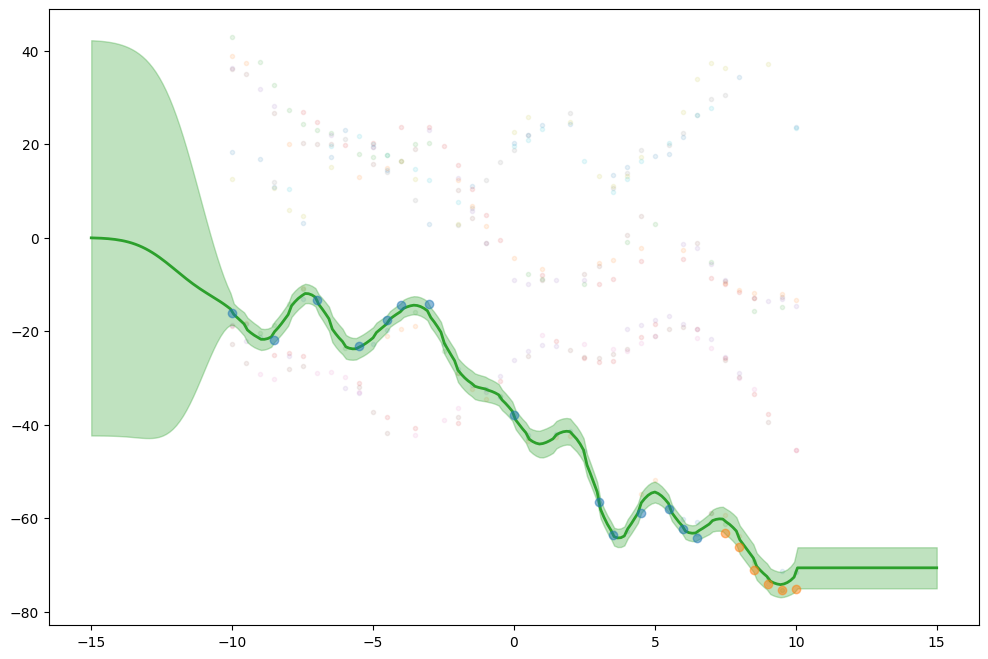

In [15]:
model.plot_predictions(plot_as="process", task_id=0)
plt.show()

---